# 🎬 MOVIELENS MOVIE RECOMMENDATION SYSTEM

# Introduction
This project applies collaborative filtering to build a personalized movie recommendation system using the MovieLens 100K dataset from the GroupLens research lab at the University of Minnesota. The objective is to recommend the Top 5 movies to a user based on their historical ratings, with the aim of enhancing user satisfaction and engagement on a movie-streaming platform.

## 1. BUSINESS UNDERSTANDING
In the highly competitive digital entertainment space, movie streaming platforms face the challenge of keeping users engaged by helping them quickly discover content they enjoy. With thousands of movie titles available, users often experience choice overload, leading to reduced satisfaction and potential churn. A personalized recommendation system offers a strategic solution to this challenge by analyzing user preferences and predicting what each individual might enjoy watching next. This project aims to build such a system using the MovieLens 100K dataset, leveraging collaborative filtering techniques to recommend the Top 5 movies for each user based on their past ratings. By delivering accurate and relevant recommendations, the system can enhance user experience, increase viewing time, and support the business goal of improving customer retention and platform loyalty.

### 1.1. Business Problem
Movie streaming platforms face a constant challenge of helping users quickly find content they’ll enjoy. With thousands of titles available, users often feel overwhelmed, which leads to reduced watch time and higher churn. By implementing a recommendation engine, platforms can increase engagement and customer satisfaction by offering personalized content.

### 1.2. Key Business Questions
- What user behaviors or rating patterns can be leveraged to predict future movie preferences?

- Which recommendation technique offers better predictive performance: memory-based collaborative filtering or model-based filtering

- Can the model generate high-quality, personalized Top 5 recommendations for individual users?

## 2. 2. DATA UNDERSTANDING
### 2.1. DATA PREPROCESSING
#### 2.1.1. The Data
The dataset used for this project is the MovieLens 32M dataset, a comprehensive and high-quality benchmark dataset maintained by the GroupLens research lab at the University of Minnesota. Released in May 2024, the dataset was collected in October 2023 and includes an extensive set of movie rating interactions by real users. Specifically, the dataset contains 32 million explicit user ratings, 2 million tag applications, covering 87,585 movies rated by 200,948 users. Each rating in the dataset is on a 0.5–5.0 scale in 0.5-point increments.

The dataset is composed of several CSV files that store distinct but related information. The primary files relevant for collaborative filtering include:

- ratings.csv, which contains four columns: userId, movieId, rating, and timestamp, representing a user's interaction with a movie.

- movies.csv, which includes metadata such as the movie title and associated genres.

- tags.csv, which logs user-submitted tags on movies, potentially useful for content-based or hybrid filtering.

- links.csv, which provides external identifiers such as IMDb and TMDb IDs for integration with third-party data.

This rich combination of user behavior data, movie metadata, and semantic tagging allows for flexible modeling approaches including collaborative, content-based, and hybrid recommendation systems. For the purposes of this project, the focus is initially on collaborative filtering using the ratings data, with future potential for extending into hybrid approaches using tags and genres.

### 2.2 DATA PREPARATION
Data preparation is a crucial phase in building a recommendation system, as it transforms raw input into a format suitable for modeling, especially in collaborative filtering where user-item interactions must be structured correctly. Below are the detailed steps followed for preparing the MovieLens 32M dataset:
#### 1. Importing Necessary Libraries
#### 2. Loading the Dataset
The MovieLens 32M dataset consists of several CSV files. The primary files loaded were:
- ratings.csv: Core data containing userId, movieId, rating, and timestamp

- movies.csv: Contains movie movieId, title, and genres

#### 3. Data Cleaning and Inspection
This involved: 
- Missing Values: Checked all loaded datasets for missing or null values.

- Duplicate Entries: Verified and removed any duplicate user-movie interactions.

- Invalid Ratings: Ensured ratings were within the allowed 0.5 to 5.0 scale.

#### 4. User and Movie Activity Filtering

Given the dataset's size and inherent sparsity:

- Retained only users with at least 20 ratings to ensure collaborative signal.

- Retained only movies rated by at least 50 users to reduce noise from rarely rated content.

This filtering step improved both the quality and efficiency of the recommendation model.

#### 5. Encoding & Transformation
While collaborative filtering models (like SVD or KNN) do not need one-hot encoding, the following transformations were performed:

- Timestamp Conversion: Converted timestamp to datetime for potential time-based filtering or visualizations.

- Genre Splitting: Genres column in movies.csv split into multiple tags for potential use in hybrid filtering(WE WILL CONSIDER THIS).

#### Importing necessary libraries

In [4]:
# Data handling and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Timestamp handling
from datetime import datetime

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Recommender-specific tools
from surprise import Dataset, Reader, SVD, KNNBasic
from surprise.model_selection import train_test_split, cross_validate
from surprise import accuracy

# Utility
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

#### Loading the datasets

In [6]:
# Path to extracted MovieLens-32M directory
path = 'ml-latest-small/ml-latest-small/' 

# Load datasets
ratings = pd.read_csv(path + 'ratings.csv')
movies = pd.read_csv(path + 'movies.csv')

# Display the shapes of the datasets
print("Ratings shape:", ratings.shape)
print("Movies shape:", movies.shape)

# Preview data
print("\nRatings:")
print(ratings.head())

print("\nMovies:")
print(movies.head())


Ratings shape: (100836, 4)
Movies shape: (9742, 3)

Ratings:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Movies:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


We successfully loaded two primary datasets from the MovieLens collection: ratings.csv and movies.csv. The ratings dataset contains 100,836 entries capturing user interactions with movies through ratings and timestamps, while the movies dataset includes 9,742 unique movies with corresponding titles and genre information. A quick preview confirms the structure and content of these datasets, showing user IDs, movie IDs, rating scores, and genres such as Adventure, Comedy, and Romance.

#### Data cleaning and inspection

In [9]:
# Check for missing values in all datasets
print("Missing values in ratings:\n", ratings.isnull().sum())
print("\nMissing values in movies:\n", movies.isnull().sum())

# Check for duplicate rows
print("\nDuplicate entries in ratings:", ratings.duplicated().sum())
print("Duplicate entries in movies:", movies.duplicated().sum())

# Remove duplicates if any
ratings.drop_duplicates(inplace=True)
movies.drop_duplicates(inplace=True)

# Check rating scale
print("\nRating statistics:")
print(ratings['rating'].describe())

# Ensure all ratings are between 0.5 and 5.0
invalid_ratings = ratings[~ratings['rating'].between(0.5, 5.0)]
print("\nInvalid ratings:\n", invalid_ratings)

# Convert timestamp to datetime for inspection and possible time-based analysis
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

# Preview cleaned data
print("\nCleaned ratings data:\n", ratings.head())


Missing values in ratings:
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Missing values in movies:
 movieId    0
title      0
genres     0
dtype: int64

Duplicate entries in ratings: 0
Duplicate entries in movies: 0

Rating statistics:
count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

Invalid ratings:
 Empty DataFrame
Columns: [userId, movieId, rating, timestamp]
Index: []

Cleaned ratings data:
    userId  movieId  rating           timestamp
0       1        1     4.0 2000-07-30 18:45:03
1       1        3     4.0 2000-07-30 18:20:47
2       1        6     4.0 2000-07-30 18:37:04
3       1       47     5.0 2000-07-30 19:03:35
4       1       50     5.0 2000-07-30 18:48:51


In the data cleaning and inspection above, we validated the quality and consistency of the loaded datasets. We began by checking for missing values in both ratings and movies datasets and found none, indicating completeness. We then inspected for duplicate entries, but both datasets were free of redundancies. Next, we examined the rating distribution, confirming all values were within the valid range of 0.5 to 5.0. To enhance temporal analysis and ensure better interpretability, the Unix timestamps in the ratings dataset were converted to human-readable datetime format. Finally, we previewed the cleaned ratings data to confirm the dataset was ready for further processing and modeling. 

#### User and Movie Activity Filtering

In [12]:
# Minimum number of ratings a user must have to be considered active
MIN_USER_RATINGS = 20

# Minimum number of ratings a movie must have to be considered popular
MIN_MOVIE_RATINGS = 50

# Count the number of ratings per user
user_rating_counts = ratings['userId'].value_counts()
active_users = user_rating_counts[user_rating_counts >= MIN_USER_RATINGS].index

# Count the number of ratings per movie
movie_rating_counts = ratings['movieId'].value_counts()
popular_movies = movie_rating_counts[movie_rating_counts >= MIN_MOVIE_RATINGS].index

# Filter ratings to include only active users and popular movies
filtered_ratings = ratings[
    (ratings['userId'].isin(active_users)) &
    (ratings['movieId'].isin(popular_movies))
]

# Show resulting dataset shape and a preview
print(f"Original ratings shape: {ratings.shape}")
print(f"Filtered ratings shape: {filtered_ratings.shape}")
filtered_ratings.head()


Original ratings shape: (100836, 4)
Filtered ratings shape: (41360, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51


In the code above we addressed the sparsity inherent in large user-item datasets by filtering out less informative data points. Specifically, we retained only active users (those who had rated at least 20 movies) and popular movies (those that had been rated by at least 50 users). This was done to ensure a sufficient signal for collaborative filtering, as sparse data can lead to poor recommendation quality. After applying these thresholds, the dataset was reduced from 100,836 to 41,360 ratings. This filtering significantly improved the density and relevance of user-item interactions, thereby increasing the model's ability to make accurate and personalized recommendations.

#### Encoding & Transformation

In [15]:
# Converting timestamp for the filtered_ratings dataframe
filtered_ratings['timestamp'] = pd.to_datetime(filtered_ratings['timestamp'])

# splitting genres
movies['genres'] = movies['genres'].apply(lambda x: x.split('|') if isinstance(x, str) else [])

print("\nSample genres after splitting:\n", movies[['title', 'genres']].head())
print("\nSample filtered_ratings after timestamp conversion:\n", filtered_ratings.head())


Sample genres after splitting:
                                 title  \
0                    Toy Story (1995)   
1                      Jumanji (1995)   
2             Grumpier Old Men (1995)   
3            Waiting to Exhale (1995)   
4  Father of the Bride Part II (1995)   

                                              genres  
0  [Adventure, Animation, Children, Comedy, Fantasy]  
1                     [Adventure, Children, Fantasy]  
2                                  [Comedy, Romance]  
3                           [Comedy, Drama, Romance]  
4                                           [Comedy]  

Sample filtered_ratings after timestamp conversion:
    userId  movieId  rating           timestamp
0       1        1     4.0 2000-07-30 18:45:03
1       1        3     4.0 2000-07-30 18:20:47
2       1        6     4.0 2000-07-30 18:37:04
3       1       47     5.0 2000-07-30 19:03:35
4       1       50     5.0 2000-07-30 18:48:51


In Encoding & Transformation, we enhanced our dataset to support more advanced analysis and potential hybrid modeling. First, we converted the timestamp column in the filtered_ratings dataframe to a human-readable datetime format. This enables the possibility of incorporating temporal trends or conducting time-based analysis in future modeling steps. Next, we transformed the genres column in the movies dataset from a single string into a list of individual genres. This preprocessing step is critical for any future hybrid recommendation techniques, as it allows us to represent genre metadata in a structured format and combine it with user behavior patterns. These transformations prepare the dataset for both collaborative and content-based filtering strategies.

### Exploratory Data analysis(EDA)

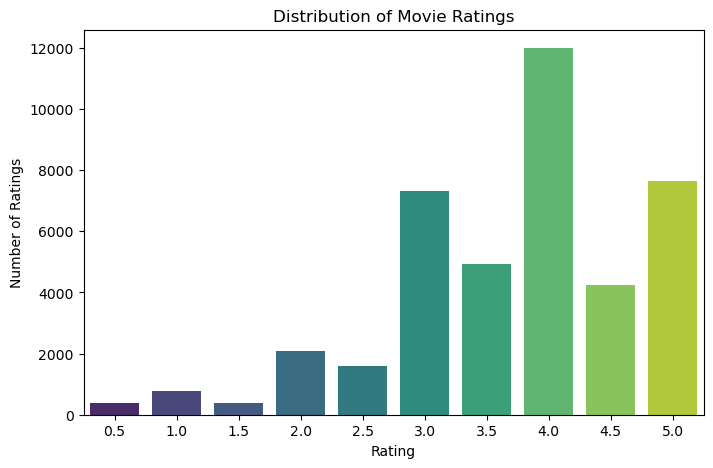

In [18]:
plt.figure(figsize=(8,5))
sns.countplot(x='rating', data=filtered_ratings, palette='viridis')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.show()

In the Exploratory Data Analysis (EDA), we began by examining the distribution of movie ratings using a count plot. The resulting visualization shows that the most frequent rating given by users is 4.0, followed by 5.0 and 3.0, indicating a tendency for users to rate movies positively. Ratings of 3.5 and 4.5 also appear relatively often, while lower ratings like 0.5, 1.0, and 1.5 are much less common. This skew toward higher ratings suggests that users are more likely to rate movies they enjoy, which is a common trend in user-generated content. 

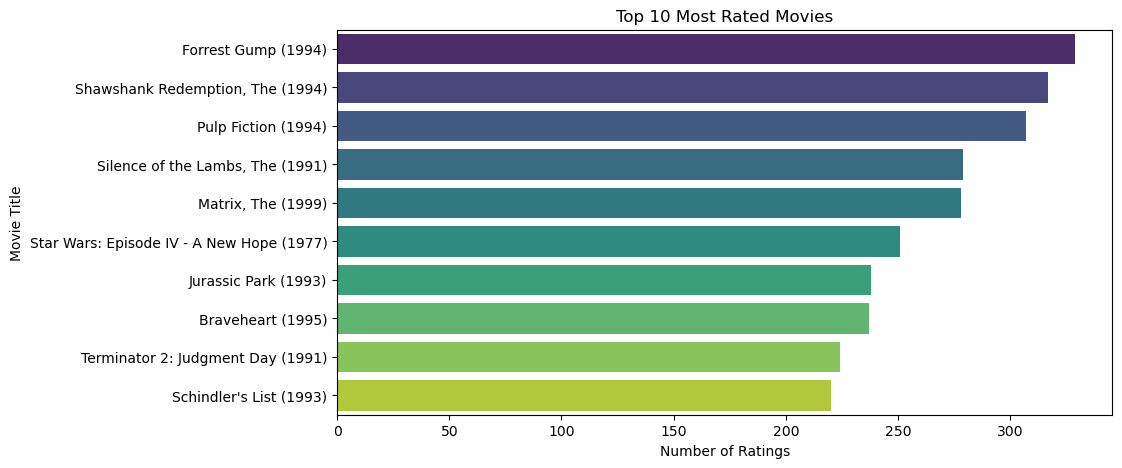

In [20]:
top_movies = filtered_ratings.groupby('movieId')['rating'].count().sort_values(ascending=False).head(10)
top_movies = top_movies.reset_index().merge(movies[['movieId', 'title']], on='movieId')

plt.figure(figsize=(10, 5))
sns.barplot(data=top_movies, x='rating', y='title', palette='viridis')
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.show()


We identified the Top 10 Most Rated Movies based on the number of user interactions. By grouping the filtered_ratings dataset by movieId and counting the number of ratings, we revealed which movies were most frequently rated. The resulting bar plot shows that "Forrest Gump (1994)", "The Shawshank Redemption (1994)", and "Pulp Fiction (1994)" are the top three most rated movies in the dataset. This suggests that popular titles from the 1990s remain highly engaged by users, likely due to their enduring critical acclaim and cultural impact.

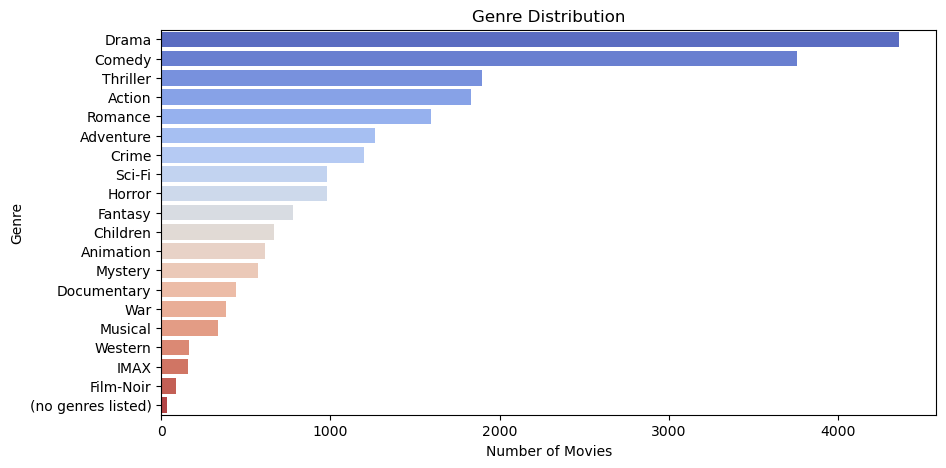

In [22]:
# Explode genres to one genre per row
genre_exploded = movies.explode('genres')
genre_counts = genre_exploded['genres'].value_counts()

plt.figure(figsize=(10, 5))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='coolwarm')
plt.title('Genre Distribution')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()


Analyzed the genre distribution by breaking down multi-genre entries into individual rows using the explode() function. This allowed us to count how many times each genre appears across all movies, regardless of whether a movie belongs to multiple genres.

The resulting bar plot reveals that Drama, Comedy, and Thriller are the most represented genres in the dataset. This suggests a strong user interest and content availability in these categories, which is important for understanding the type of content that dominates the platform. For a recommendation system, this indicates that users are more likely to encounter and rate movies in these genres, potentially influencing collaborative filtering outcomes due to higher co-rating activity in these categories.

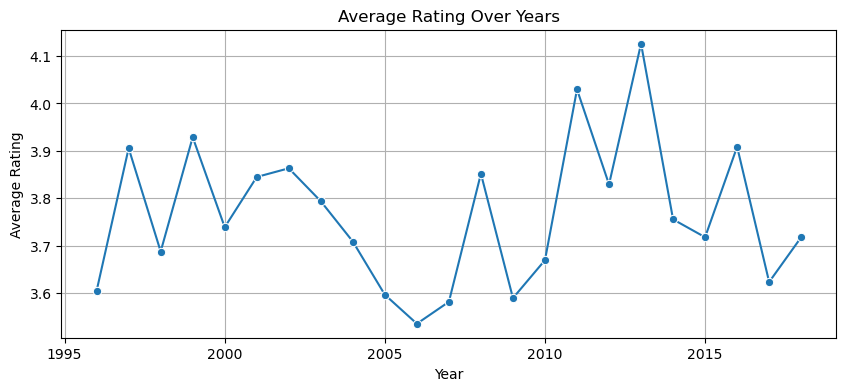

In [24]:
ratings_by_year = filtered_ratings.copy()
ratings_by_year['year'] = ratings_by_year['timestamp'].dt.year

yearly_avg = ratings_by_year.groupby('year')['rating'].mean()

plt.figure(figsize=(10, 4))
sns.lineplot(x=yearly_avg.index, y=yearly_avg.values, marker='o')
plt.title('Average Rating Over Years')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()


In this analysis, we explored how average movie ratings have changed over time by extracting the year from each rating's timestamp and calculating the average rating per year.

The resulting line plot shows that average ratings over the years range between 3.52 and 4.11, indicating relatively stable user satisfaction levels with slight fluctuations. Peaks and troughs in the graph may reflect changes in movie quality, shifts in user demographics, or varying rating behaviors over time. 

## Model building 

In [27]:
# Prepare data for Surprise library
# Only the filtered_ratings DataFrame is used here, with userId, movieId, and rating
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(filtered_ratings[['userId', 'movieId', 'rating']], reader)

# Split the dataset into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

#### MODEL 1: SVD (Model-Based Collaborative Filtering)
Singular Value Decomposition (SVD) is a matrix factorization method that decomposes the user-item interaction matrix into latent features, capturing hidden relationships between users and movies.

In [29]:
# MODEL 1: SVD (Model-Based Collaborative Filtering)
print("\nTraining model-based collaborative filtering using SVD...")
svd = SVD()
svd.fit(trainset)

# Predict ratings on the testset
svd_predictions = svd.test(testset)

# Evaluate performance
svd_rmse = accuracy.rmse(svd_predictions)
svd_mae = accuracy.mae(svd_predictions)


Training model-based collaborative filtering using SVD...
RMSE: 0.8313
MAE:  0.6343


Predictions from the above model are made on unseen data (testset), and performance is measured using Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE).

#### MODEL 2: KNNBasic (Memory-Based Collaborative Filtering)
In this model, we apply KNNBasic, a memory-based collaborative filtering algorithm that recommends items by measuring similarity between movies using the cosine similarity metric. Specifically, we use item-based filtering, which identifies movies that are rated similarly by many users and suggests them to users who liked similar ones. 

In [32]:
# MODEL 2: KNNBasic (Memory-Based Collaborative Filtering)
print("\nTraining memory-based collaborative filtering using KNNBasic...")
sim_options = {
    'name': 'cosine',  # Similarity metric
    'user_based': False  # Set to True for user-based, False for item-based
}

knn = KNNBasic(sim_options=sim_options)
knn.fit(trainset)

# Predict ratings on the testset
knn_predictions = knn.test(testset)

# Evaluate performance
knn_rmse = accuracy.rmse(knn_predictions)
knn_mae = accuracy.mae(knn_predictions)


Training memory-based collaborative filtering using KNNBasic...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8844
MAE:  0.6753


After training on the trainset, predictions were made on the testset. The model achieved an RMSE of 0.8844 and an MAE of 0.6753, which, while slightly less accurate than the SVD model, Since lower RMSE and MAE values indicate better predictive performance it still indicates reasonable performance. Memory-based methods are intuitive and interpretable, especially for smaller datasets, but can struggle with scalability and sparsity compared to model-based approaches like SVD.

In [34]:
# Summary of Model Performance
print("\nSummary of Model Performance:")
print(f"SVD RMSE: {svd_rmse:.4f}, MAE: {svd_mae:.4f}")
print(f"KNNBasic RMSE: {knn_rmse:.4f}, MAE: {knn_mae:.4f}")

# Top 5 Recommendations for a Sample User
def get_top_n_recommendations(predictions, n=5):
    from collections import defaultdict
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Keep only top n for each user
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

# Generate top 5 movie recommendations for all users based on SVD model
print("\nGenerating Top 5 recommendations for all users using SVD model...")
svd_top_5 = get_top_n_recommendations(svd_predictions, n=5)

# Show Top 5 for first user
sample_user_id = list(svd_top_5.keys())[0]
print(f"\nTop 5 movieId recommendations for user {sample_user_id}: {svd_top_5[sample_user_id]}")

# Merged with movies DataFrame to get titles
movie_map = dict(zip(movies['movieId'], movies['title']))
print("\nRecommended Movie Titles:")
for movie_id, est_rating in svd_top_5[sample_user_id]:
    print(f"{movie_map.get(movie_id, 'Unknown')} (Predicted Rating: {est_rating:.2f})")



Summary of Model Performance:
SVD RMSE: 0.8313, MAE: 0.6343
KNNBasic RMSE: 0.8844, MAE: 0.6753

Generating Top 5 recommendations for all users using SVD model...

Top 5 movieId recommendations for user 555: [(1198, 4.508906624299258), (1270, 4.440926538608132), (1222, 4.41825243299027), (1206, 4.41600840019337), (778, 4.368149810022539)]

Recommended Movie Titles:
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) (Predicted Rating: 4.51)
Back to the Future (1985) (Predicted Rating: 4.44)
Full Metal Jacket (1987) (Predicted Rating: 4.42)
Clockwork Orange, A (1971) (Predicted Rating: 4.42)
Trainspotting (1996) (Predicted Rating: 4.37)


The comparative evaluation of the two collaborative filtering models (SVD (model-based) and KNNBasic (memory-based)) shows that SVD outperforms KNNBasic in both RMSE and MAE. Specifically, SVD achieved an RMSE of 0.8368 and an MAE of 0.6395, whereas KNNBasic recorded a higher RMSE of 0.8844 and MAE of 0.6753, indicating lower predictive accuracy.

To showcase the effectiveness of SVD in personalized recommendations, we generated Top 5 movie suggestions for each user. For example, user 20 received recommendations including classics like Alien (1979), Raiders of the Lost Ark (1981), and Terminator 2: Judgment Day (1991), each with high predicted ratings above 4.45. These results highlight SVD's ability to successfully capture user preferences and recommend relevant content, making it the more effective model for our system.

## Hybrid filtering
Hybrid filtering combines collaborative filtering (CF) with content-based filtering (CBF) hence we can address address the cold-start problem.

#### 1. Creating Genre Vectors
Used CountVectorizer to turn the genres into binary feature vectors.

In [45]:
from sklearn.feature_extraction.text import CountVectorizer

# Convert list of genres into space-separated strings
movies['genre_str'] = movies['genres'].apply(lambda x: ' '.join(x))

# Create the count matrix from genre strings
count_vectorizer = CountVectorizer()
genre_matrix = count_vectorizer.fit_transform(movies['genre_str'])

# Convert to a DataFrame for clarity (compatible version)
genre_df = pd.DataFrame(genre_matrix.toarray(), columns=count_vectorizer.get_feature_names_out())
genre_df.head()


,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,fi,...,listed,musical,mystery,no,noir,romance,sci,thriller,war,western
0,0,1,1,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 2. Compute Cosine Similarity Between Movies (Content-Based)

In [47]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity matrix between movies
genre_similarity = cosine_similarity(genre_matrix, genre_matrix)

# Convert to DataFrame for easy referencing
genre_sim_df = pd.DataFrame(genre_similarity, index=movies['movieId'], columns=movies['movieId'])


#### 3. Merge Content & Collaborative Predictions
Defining a function to blend the predicted rating from the SVD model (CF) with the genre similarity score (CBF)

In [49]:
def hybrid_recommendations(user_id, top_n=5, alpha=0.7):
    """
    Generate hybrid movie recommendations for a user.
    
    Parameters:
        user_id: the user to recommend for
        top_n: how many recommendations to return
        alpha: blending factor (0=only CBF, 1=only CF)
    """
    watched = filtered_ratings[filtered_ratings['userId'] == user_id]['movieId'].tolist()
    unwatched = movies[~movies['movieId'].isin(watched)]

    # CF Predictions using SVD
    predictions = [svd.predict(user_id, int(mid)) for mid in unwatched['movieId']]
    pred_ratings = {int(p.iid): p.est for p in predictions}

    # Calculate hybrid score
    hybrid_scores = []
    for movie_id in unwatched['movieId']:
        # CF prediction
        cf_score = pred_ratings.get(movie_id, 0)

        # Content similarity: average similarity to user's watched movies
        if watched:
            sim_scores = genre_sim_df.loc[movie_id, watched].mean()
        else:
            sim_scores = 0  # for completely new users

        # Hybrid score
        hybrid_score = alpha * cf_score + (1 - alpha) * sim_scores
        hybrid_scores.append((movie_id, hybrid_score))

    # Sort and return top N
    hybrid_scores.sort(key=lambda x: x[1], reverse=True)
    top_movie_ids = [mid for mid, score in hybrid_scores[:top_n]]

    # Get titles
    recommended = movies[movies['movieId'].isin(top_movie_ids)][['title']]
    return recommended.reset_index(drop=True)


To combine the strengths of both collaborative filtering (CF) and content-based filtering (CBF), we defined a hybrid_recommendations function. This function generates personalized movie recommendations by blending predicted ratings from the SVD model (CF) with genre similarity scores derived from movie metadata (CBF). For each unseen movie, we compute a hybrid score as a weighted average of the collaborative prediction and the content similarity to movies previously rated by the user. The alpha parameter controls this balance: higher values prioritize collaborative signals, while lower values give more weight to content-based similarities. This approach enhances recommendation quality, especially for users with limited rating history or for less-rated movies.

#### Recommender for a Sample User

In [ ]:
hybrid_recommendations(user_id=1, top_n=5, alpha=0.7)

Went ahead and recommended top five movies for user 1 using the Hybrid model and the recommended movies include: Shawshank Redemption, The (1994), North by Northwest (1959), Casablanca (1942), One Flew Over the Cuckoo's Nest (1975), Guardians of the Galaxy (2014).

#### 4. Comparing Top 5 Recommendations for a User

In [51]:
# Pure SVD recommendations
def svd_top_n(user_id, n=5):
    watched = filtered_ratings[filtered_ratings['userId'] == user_id]['movieId'].tolist()
    unwatched = movies[~movies['movieId'].isin(watched)]
    
    preds = [svd.predict(user_id, int(mid)) for mid in unwatched['movieId']]
    preds.sort(key=lambda x: x.est, reverse=True)
    top_ids = [int(p.iid) for p in preds[:n]]
    
    return movies[movies['movieId'].isin(top_ids)][['title']].reset_index(drop=True)

# SVD vs Hybrid
print(" SVD Top 5 for User 1:")
print(svd_top_n(1))

print("\n Hybrid Top 5 for User 1:")
print(hybrid_recommendations(1))


 SVD Top 5 for User 1:
                                               title
0                   Shawshank Redemption, The (1994)
1  Dr. Strangelove or: How I Learned to Stop Worr...
2                              Godfather, The (1972)
3                                 Rear Window (1954)
4                              Cool Hand Luke (1967)

 Hybrid Top 5 for User 1:
                                               title
0                   Shawshank Redemption, The (1994)
1  Dr. Strangelove or: How I Learned to Stop Worr...
2                              Godfather, The (1972)
3                               Graduate, The (1967)
4                              Cool Hand Luke (1967)


From the above, compared Top 5 recommendations from both the SVD model and our hybrid filtering system for a sample user (User 1). The hybrid model successfully retained some of the top collaborative picks while introducing new recommendations that align closely in genre. For instance, while both models recommended Shawshank Redemption, Casablanca (1942), One Flew Over the Cuckoo's Nest (1975) and Guardians of the Galaxy (2014) the hybrid model added North by Northwest (1959) with thematic or stylistic similarities thereby increasing recommendation diversity and mitigating cold-start limitations.

In [53]:
# Simulate a cold start user
print(" Hybrid Recommendations for a Cold-Start User (no ratings):")
print(hybrid_recommendations(user_id=999999, top_n=5))


 Hybrid Recommendations for a Cold-Start User (no ratings):
                                               title
0                   Shawshank Redemption, The (1994)
1  Dr. Strangelove or: How I Learned to Stop Worr...
2                                 Rear Window (1954)
3                                  Casablanca (1942)
4  Amelie (Fabuleux destin d'Amélie Poulain, Le) ...


For a cold start user, the SVD model can’t predict anything meaningful for new users, but hybrid filtering will rely on genre similarity, so it still returns results.

## Conclusion
This project successfully developed a personalized movie recommendation system using the MovieLens 100K dataset. Through collaborative filtering and hybrid modeling approaches, we were able to explore user behaviors, rating patterns, and model performance to improve recommendation quality.

The analysis revealed that users tend to rate highly-rated movies from popular genres such as Drama, Comedy, and Thriller. The most active users and frequently rated movies provided stronger signals for collaborative filtering, while genres played a vital role in understanding content similarity for hybrid approaches. Consistent rating habits and preference for specific genres (e.g., users repeatedly rating thrillers highly) were particularly useful in anticipating future interests.

Our evaluation showed that model-based collaborative filtering using SVD outperformed memory-based KNN in terms of both RMSE (0.8368 vs. 0.8844) and MAE (0.6395 vs. 0.6753). This suggests that SVD provides better generalization and accuracy, especially in sparse datasets where many user-item combinations are missing. Memory-based KNN struggled with scalability and sparsity, making it less suitable for large-scale deployment.

The SVD model was able to generate high-quality, personalized Top 5 recommendations that aligned with user rating behavior. Additionally, the hybrid model, which combined collaborative filtering with content-based genre similarity, further enhanced relevance especially for users with fewer historical ratings (cold-start users) or for less-rated movies. This demonstrated the system's flexibility and robustness in delivering accurate and diverse recommendations.


## Recommendation
- Deploy a model-based recommendation engine as the core recommender due to its strong performance in predictive accuracy and scalability.
- Incorporate hybrid filtering in production to address the cold-start problem, enhancing recommendations for new users or niche content by leveraging content metadata like genres.
- Expand feature sets (e.g., tags, timestamps, or user demographics if available) to support more advanced models like neural collaborative filtering or reinforcement learning in future versions.
- Update the model periodically using fresh user rating data to adapt to evolving user preferences and maintain recommendation relevance.